In [1]:
#Libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# modeling and evaluating
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# Exploring
import scipy.stats as stats
import math

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib inline

# Add more libraries below this line as needed.

In [2]:
import os
import env
import acquire
import wrangle
import wrangle_zillow_new

credentials loaded successfully
End of file.
Loaded zillow wrangle functions successfully.
Imported prepare.py successfully


In [3]:
df = wrangle.get_zillow_data()
df.shape

(77381, 70)

In [4]:
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,logerror,pid,tdate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,0.025595,14297519,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,0.055619,17052889,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,0.005383,14186244,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,-0.103410,12177905,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,0.006940,10887214,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77381 non-null  float64
 4   heatingorsystemtypeid         49440 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   id                            77381 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77381 non-null  float64
 11  bedroomcnt                    77381 non-null  float64
 12  buildingqualitytypeid         49672 non-null  float64
 13  c

### First step, remove columns that I know I won't be needing

A lot of missing values, however I will remove the columns I don't think I'll be needing first, then address missing rows.

In [6]:
# Dropping columns I don't think I'll need. If I do end up needing them, come back to this point after the MVP is done.

df = wrangle.drop_cols(df)
df.shape

(77381, 49)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77381 non-null  float64
 3   buildingclasstypeid           15 non-null     float64
 4   architecturalstyletypeid      206 non-null    float64
 5   airconditioningtypeid         24953 non-null  float64
 6   basementsqft                  50 non-null     float64
 7   bathroomcnt                   77381 non-null  float64
 8   bedroomcnt                    77381 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet13          41 non-null     float64
 13  f

In [8]:
# I need to isolate down to only single unit properties, which equate to this list:

id_list = [261.0, 260.0, 262.0, 263.0, 264.0]

In [9]:
# Now I have 20k less rows, so good for the most part. Now need to cut down the columns:

df = wrangle.prep_data(df, id_list)
df.shape

(52244, 49)

In [10]:
df = wrangle.handle_missing_values(df, col_limit = .6, row_limit = .6)
df.shape

(52244, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52244 entries, 0 to 77380
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52244 non-null  float64
 1   bathroomcnt                   52244 non-null  float64
 2   bedroomcnt                    52244 non-null  float64
 3   calculatedfinishedsquarefeet  52236 non-null  float64
 4   fips                          52244 non-null  float64
 5   latitude                      52244 non-null  float64
 6   longitude                     52244 non-null  float64
 7   lotsizesquarefeet             51883 non-null  float64
 8   roomcnt                       52244 non-null  float64
 9   yearbuilt                     52204 non-null  float64
 10  structuretaxvaluedollarcnt    52172 non-null  float64
 11  taxvaluedollarcnt             52243 non-null  float64
 12  landtaxvaluedollarcnt         52243 non-null  float64
 13  t

In [12]:
# I don't need this column any more.
df.drop(columns = ['propertylandusetypeid'], inplace = True)


In [13]:
df.isna().sum().sort_values(ascending = False)

lotsizesquarefeet               361
structuretaxvaluedollarcnt       72
yearbuilt                        40
calculatedfinishedsquarefeet      8
taxamount                         4
landtaxvaluedollarcnt             1
taxvaluedollarcnt                 1
logerror                          0
roomcnt                           0
longitude                         0
latitude                          0
fips                              0
bedroomcnt                        0
bathroomcnt                       0
dtype: int64

In [14]:
df = df.dropna()
df.isna().sum().sort_values(ascending = False)

logerror                        0
taxamount                       0
landtaxvaluedollarcnt           0
taxvaluedollarcnt               0
structuretaxvaluedollarcnt      0
yearbuilt                       0
roomcnt                         0
lotsizesquarefeet               0
longitude                       0
latitude                        0
fips                            0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
bathroomcnt                     0
dtype: int64

## Things on my mind:

- Will clustering be beneficial to my understanding of the data and relationships
- Are there new features I can create from my current feature list that will do a better job of predicting `logerror`?

In [15]:
pd.set_option('display.max_columns', 40)

# Adding new dummy columns:

county_df = pd.get_dummies(df.fips)
county_df.head(1)

county_df.columns = ["LA", "Orange", "Ventura"]
# df_dummies = pd.concat([df, county_df], axis = 1)
df = pd.concat([df, county_df], axis = 1)
print(df.shape)
df.head(1)

(51780, 17)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura
0,3.5,4.0,3100.0,6059.0,33.634931,-117.869207,4506.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0


In [16]:
# adding features:

def create_features(df):
    df['age'] = 2017 - df.yearbuilt

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt
    
    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560
    
    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet

    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    # ratio of beds to baths
    df['bed_bath_ratio'] = df.bedroomcnt/df.bathroomcnt
    
    
    
    return df

In [17]:
df = create_features(df)

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

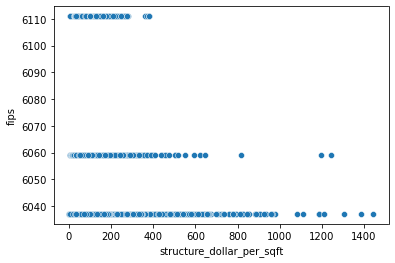

In [18]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

# Note there are only about 8 outliers that are making the 4th quartile to the max value extremely large compared to the rest of the quartiles.
# These kind of outliers will greatly affect the clustering models. Need to remove them.

In [19]:
# Need to remove outliers because outliers have a very large negative impact on clustering.

def remove_outliers():
    '''
    remove outliers in in structure dollars and land dollars.
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 10) &
               (df.calculatedfinishedsquarefeet < 7000) & 
               (df.taxrate < .05) &
               (df.structure_dollar_per_sqft < 1001) &
               (df.land_dollar_per_sqft < 1501)
              )]

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

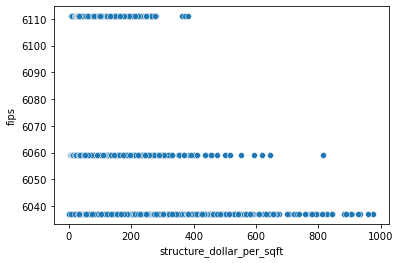

In [20]:
df = remove_outliers()
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

<AxesSubplot:xlabel='land_dollar_per_sqft', ylabel='structure_dollar_per_sqft'>

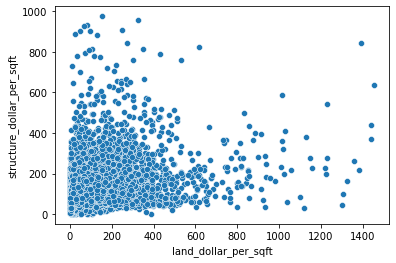

In [21]:
sns.scatterplot(x = 'land_dollar_per_sqft', y = 'structure_dollar_per_sqft', data = df)

In [22]:
df.isnull().sum().sort_values(ascending = False)

bed_bath_ratio                  0
taxvaluedollarcnt               0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
landtaxvaluedollarcnt           0
land_dollar_per_sqft            0
taxamount                       0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
bathroomcnt                     0
dtype: int64

In [23]:
df_la = df[df.LA == 1].drop(columns = ['Orange', 'Ventura'])
df_la.shape

(33153, 21)

In [24]:
df_o = df[df.Orange == 1].drop(columns = ['LA', 'Ventura'])
df_v = df[df.Ventura == 1].drop(columns = ['Orange', 'LA'])
df_o.shape, df_v.shape

((13937, 21), (4315, 21))

In [25]:
df_la.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
3,3.0,4.0,2376.0,6037.0,34.24518,-118.240722,13038.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.10341,1,47.0,0.012247,0.299311,45.840909,2.778417,1.333333


In [26]:
# Checking to see the count of fips in each new county df. Making sure there wasn't any leakage between them.

df_la.fips.value_counts(), df_o.fips.value_counts(), df_v.fips.value_counts(),

(6037.0    33153
 Name: fips, dtype: int64,
 6059.0    13937
 Name: fips, dtype: int64,
 6111.0    4315
 Name: fips, dtype: int64)

At this point, I'd want to do everything in triplets, but I think that'll take too long so I'm going to continue using the main dataframe and just add a county column so that I can still divide things by county.

I'll end up with 3 dataframes per county df, which means a total of 9 dataframes... That seems like a bit much, at least for an MVP.

In [27]:
# I no longer need this column:

# df = df.drop(columns = "propertylandusetypeid")
# df.drop(columns = ['regionidcity', 'regionidcounty', 'unitcnt'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51405 entries, 0 to 77380
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51405 non-null  float64
 1   bedroomcnt                    51405 non-null  float64
 2   calculatedfinishedsquarefeet  51405 non-null  float64
 3   fips                          51405 non-null  float64
 4   latitude                      51405 non-null  float64
 5   longitude                     51405 non-null  float64
 6   lotsizesquarefeet             51405 non-null  float64
 7   roomcnt                       51405 non-null  float64
 8   yearbuilt                     51405 non-null  float64
 9   structuretaxvaluedollarcnt    51405 non-null  float64
 10  taxvaluedollarcnt             51405 non-null  float64
 11  landtaxvaluedollarcnt         51405 non-null  float64
 12  taxamount                     51405 non-null  float64
 13  l

In [29]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
0,3.5,4.0,3100.0,6059.0,33.634931,-117.869207,4506.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0,19.0,0.010763,0.103444,156.681613,119.300710,1.142857
1,1.0,2.0,1465.0,6111.0,34.449266,-119.281531,12647.0,5.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,0,0,1,50.0,0.012225,0.290335,60.068259,29.730371,2.000000
2,2.0,3.0,1243.0,6059.0,33.886168,-117.823170,8432.0,6.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,0,1,0,55.0,0.011488,0.193572,68.615447,56.865394,1.500000
3,3.0,4.0,2376.0,6037.0,34.245180,-118.240722,13038.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,1,0,0,47.0,0.012247,0.299311,45.840909,2.778417,1.333333
6,3.0,4.0,2962.0,6037.0,34.145202,-118.179824,63000.0,0.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,1,0,0,67.0,0.012306,1.446281,93.411209,7.882841,1.333333


## Splitting Data

In [30]:
train, validate, test = wrangle.split_zillow_data(df)

Shape of train df: (34955, 23)
Shape of validate df: (8739, 23)
Shape of test df: (7711, 23)


In [31]:
# Impute missing values
train.isna().sum().sort_values(ascending = False)

bed_bath_ratio                  0
taxvaluedollarcnt               0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
landtaxvaluedollarcnt           0
land_dollar_per_sqft            0
taxamount                       0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
bathroomcnt                     0
dtype: int64

In [ ]:
# No need to run this since there are no missing values...

train, validate, test = wrangle.impute_missing_values_all(train, validate, test)
train.head()

# Don't forget to .cut() in this area
# bin by age of house, county, tax bracket, and sq footage for starters

In [33]:
def split(df, target_var):
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [34]:
def split_new(train, validate, test, target_var):
#     # split df into train_validate (80%) and test (20%)
#     train_validate, test = train_test_split(df, test_size=.20, random_state=13)
#     # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
#     train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [37]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split(df, 'logerror')
X_train.shape, X_validate.shape, X_test.shape

((28786, 22), (12338, 22), (10281, 22))

In [38]:
X_train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
58160,1.5,3.0,1049.0,6059.0,33.811954,-118.032864,6000.0,5.0,1962.0,61751.0,209380.0,147629.0,2568.94,0,1,0,55.0,0.012269,0.137741,58.866540,24.604833,2.000000
69027,1.5,2.0,1290.0,6059.0,33.417872,-117.591748,1188.0,5.0,1977.0,108638.0,547000.0,438362.0,5555.48,0,1,0,40.0,0.010156,0.027273,84.215504,368.991582,1.333333
60376,1.5,3.0,1288.0,6111.0,34.273039,-119.271961,6017.0,5.0,1948.0,51638.0,263516.0,211878.0,2787.54,0,0,1,69.0,0.010578,0.138131,40.091615,35.213229,2.000000
50394,1.0,2.0,1196.0,6037.0,33.968417,-118.325053,6700.0,0.0,1929.0,22755.0,42196.0,19441.0,832.97,1,0,0,88.0,0.019740,0.153811,19.025920,2.901642,2.000000
30686,2.5,4.0,2588.0,6059.0,33.544862,-117.633459,3698.0,0.0,2003.0,317477.0,717538.0,400061.0,10427.62,0,1,0,14.0,0.014532,0.084894,122.672720,108.183072,1.600000


In [ ]:
# X_train, y_train, X_validate, y_validate, X_test, y_test = split_new(train, validate, test, 'logerror')

In [ ]:
X_train.isnull().sum()

In [39]:
def scale_min_max():
    # create the scaler object and fit to X_train (get the min and max from X_train for each column)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)

    # transform X_train values to their scaled equivalent and create df of the scaled features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns.values).set_index([X_train.index.values])
    
    # transform X_validate values to their scaled equivalent and create df of the scaled features
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate),
                                    columns=X_validate.columns.values).set_index([X_validate.index.values])

    # transform X_test values to their scaled equivalent and create df of the scaled features   
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns.values).set_index([X_test.index.values])
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [40]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_min_max()

In [41]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
58160,0.083333,0.333333,0.111925,0.297297,0.294176,0.751024,0.013250,0.357143,0.587786,0.013324,0.007793,0.006473,0.008735,0.0,1.0,0.0,0.412214,0.241254,0.013250,0.061333,0.016904,0.357143
69027,0.083333,0.166667,0.147938,0.297297,0.017906,0.980679,0.002188,0.357143,0.702290,0.023465,0.021101,0.019491,0.019088,0.0,1.0,0.0,0.297710,0.198119,0.002188,0.087762,0.253643,0.214286
60376,0.083333,0.333333,0.147639,1.000000,0.617419,0.105923,0.013289,0.357143,0.480916,0.011137,0.009927,0.009350,0.009493,0.0,0.0,1.0,0.519084,0.206734,0.013289,0.041758,0.024197,0.357143
50394,0.000000,0.166667,0.133891,0.000000,0.403864,0.598904,0.014859,0.000000,0.335878,0.004890,0.001203,0.000733,0.002717,1.0,0.0,0.0,0.664122,0.393771,0.014859,0.019795,0.001985,0.357143
30686,0.250000,0.500000,0.341901,0.297297,0.106932,0.958963,0.007958,0.000000,0.900763,0.068635,0.027823,0.017776,0.035977,0.0,1.0,0.0,0.099237,0.287455,0.007958,0.127858,0.074358,0.271429


In [42]:
X_train_scaled.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio                  0
dtype: int64

In [43]:
X_train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
count,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,2.878600e+04,2.878600e+04,2.878600e+04,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000,28786.000000
mean,2.284861,3.301709,1894.002466,6049.137567,34.021682,-118.192972,9659.085493,1.921107,1963.190231,1.876545e+05,5.076849e+05,3.200304e+05,6177.786665,0.644619,0.272320,0.083061,53.809769,0.013191,0.221742,89.826233,48.046356,1.605032
std,0.968420,0.909500,901.158004,20.960457,0.273460,0.355737,16024.208183,3.158044,22.897599,2.032609e+05,5.989845e+05,4.515303e+05,6881.085787,0.478637,0.445161,0.275980,22.897599,0.003057,0.367865,56.044945,68.361654,0.567165
min,1.000000,1.000000,300.000000,6037.000000,33.392330,-119.475416,236.000000,0.000000,1885.000000,1.480000e+02,1.168300e+04,3.080000e+03,49.180000,0.000000,0.000000,0.000000,1.000000,0.000451,0.005418,0.039833,0.013963,0.333333
25%,2.000000,3.000000,1269.000000,6037.000000,33.826994,-118.399111,5573.000000,0.000000,1950.000000,7.708125e+04,1.943005e+05,7.614300e+04,2647.540000,0.000000,0.000000,0.000000,38.000000,0.011636,0.127938,54.991838,9.602334,1.250000
50%,2.000000,3.000000,1650.000000,6037.000000,34.017868,-118.151458,6822.000000,0.000000,1960.000000,1.305350e+05,3.730000e+05,2.181675e+05,4638.205000,1.000000,0.000000,0.000000,57.000000,0.012321,0.156612,81.596949,30.487417,1.500000
75%,3.000000,4.000000,2278.000000,6059.000000,34.186966,-117.929769,8736.750000,5.000000,1979.000000,2.215290e+05,6.125015e+05,4.069772e+05,7290.652500,1.000000,1.000000,0.000000,67.000000,0.013662,0.200568,112.553470,60.131714,2.000000
max,7.000000,7.000000,6992.000000,6111.000000,34.818767,-117.554636,435267.000000,14.000000,2016.000000,4.623607e+06,2.538125e+07,2.233550e+07,288524.600000,1.000000,1.000000,1.000000,132.000000,0.049437,9.992355,959.175145,1454.724936,5.000000


## End of prep:

- All missing values accounted for
- All columns still in dataframe are ones I need for analysis
- Data not yet scaled, need to accomplish this before moving on with rest of Explore stage

## *Outliers still need to be dealt with after the MVP is complete*

# Explore Stage

- Based on Faith's advice for the MVP, I will be exploring based upon unscaled train, validate, and test data.
- However, when it comes time to model, I'll need to scale the data. I would prefer to have that step completed at end of prep, so will add scaling section here
### y_train ==  `logerror`

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='logerror'>

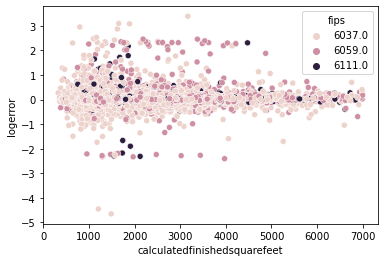

In [44]:
# For a simple visual answer, I'm going to use a scatterplot, with logerror being the value.

sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data = train, hue = 'fips')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

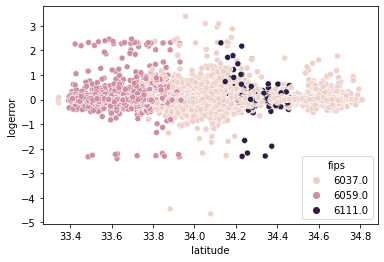

In [45]:
sns.scatterplot(x = 'latitude', y = 'logerror', data = train, hue = 'fips')

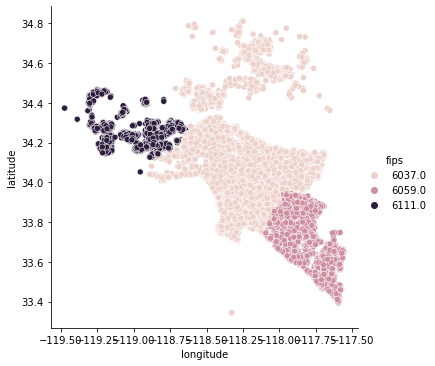

In [46]:
sns.relplot(x="longitude", y="latitude", hue="fips", data=train)

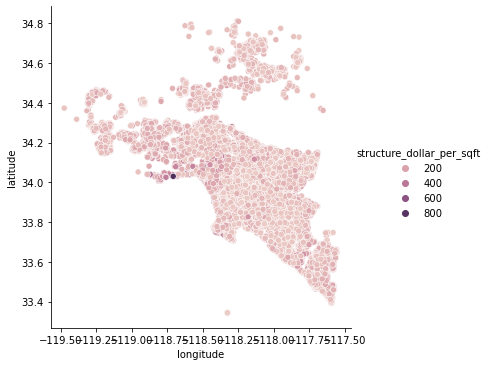

In [47]:
sns.relplot(x="longitude", y="latitude", hue="structure_dollar_per_sqft", data=train)

In [ ]:
# Are there any features that I want to create from the existing data? Any I want to take away?
# First let's check the distributions of the existing cleaned columns:

## Can I visualize any significant relationship between logerror and any of my current features?

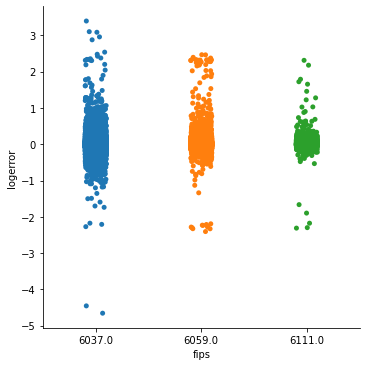

In [48]:
# I'm not seeing any... And if I can't find any, not sure what to test or model on...

sns.catplot(x = 'fips', y = 'logerror', data = train)

In [49]:
# What should I bit? How effective would that be? Let's run histograms to see what the distributions are:

In [51]:
area_vars = ['latitude', 'longitude', 'age']

def elbow_plot(cluster_vars):
    # elbow method to identify good k for us
    ks = range(2,20)
    
    # empty list to hold inertia (sum of squares)
    sse = []

    # loop through each k, fit kmeans, get inertia
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train[cluster_vars])
        # inertia
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    # plot k with inertia
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow method to find optimal k')
    plt.show()

     k           sse
0    2  5.237157e+06
1    3  2.376292e+06
2    4  1.319869e+06
3    5  8.886268e+05
4    6  6.447557e+05
5    7  4.572815e+05
6    8  3.449649e+05
7    9  2.809718e+05
8   10  2.291221e+05
9   11  1.791872e+05
10  12  1.593476e+05
11  13  1.411152e+05
12  14  1.276539e+05
13  15  1.138134e+05
14  16  1.015110e+05
15  17  9.194750e+04
16  18  8.388393e+04
17  19  7.601451e+04


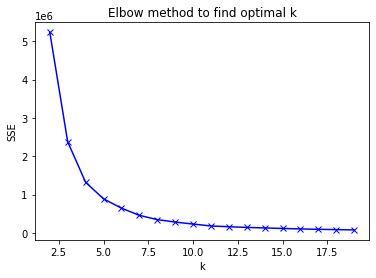

In [53]:
elbow_plot(cluster_vars = area_vars)

In [54]:
# Based on this is seems like 4-5 centroids is the optimal number of clusters for our data.

### Questions:

- Do I need to bin anything?
- What is the average tax rate per county?
- combine tax amount and square feet by county and compare

In [ ]:
# heatmap_df = train(scale this)

<AxesSubplot:>

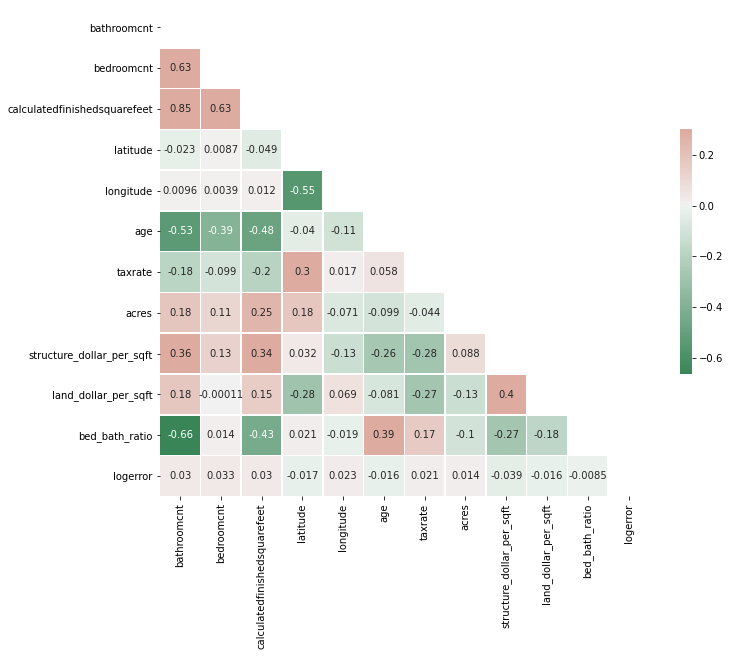

In [56]:
# going to try all columns:

# Creating a dataframe for a more managable heatmap
# corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'county', 'logerror']]
corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'logerror']]

# Code for the heatmap itself:
corr = corr_eval_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [109]:
# Need to go back and figure out if I can get a scaled dataset using logerror

# Creating a dataframe for a more managable heatmap
# corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'county', 'logerror']]
corr_eval_df = train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'logerror']]

# Code for the heatmap itself:
corr = corr_eval_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

NameError: name 'train_scaled' is not defined

#### Takeaways:
- Right now the highest correlation is `fullbathcnt` and `age`
- But none of these features actually are over the limit of .2 or -.2 to become remotely "significant"

This correlation matrix usually provides some hints as to which features are statistically correlated to the target variable, ie `logerror` in this case...

Still, I need to take whatever the MOST significant features are and go with those... at least for the MVP

In [ ]:
# So log error is higher in orange county...? Interesting.

# What types of houses are predominant in Orange county? Low priced, high priced, normal "family" priced homes?

# Is the model worse at predicting middle income type homes, and better at the outliers?



# Clustering

In [62]:
from sklearn.cluster import KMeans

In [64]:

# Fit K-Means
X = X_train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
58160,0.083333,0.333333,0.111925,0.297297,0.294176,0.751024,0.013250,0.357143,0.587786,0.013324,0.007793,0.006473,0.008735,0.0,1.0,0.0,0.412214,0.241254,0.013250,0.061333,0.016904,0.357143,0
69027,0.083333,0.166667,0.147938,0.297297,0.017906,0.980679,0.002188,0.357143,0.702290,0.023465,0.021101,0.019491,0.019088,0.0,1.0,0.0,0.297710,0.198119,0.002188,0.087762,0.253643,0.214286,3
60376,0.083333,0.333333,0.147639,1.000000,0.617419,0.105923,0.013289,0.357143,0.480916,0.011137,0.009927,0.009350,0.009493,0.0,0.0,1.0,0.519084,0.206734,0.013289,0.041758,0.024197,0.357143,2
50394,0.000000,0.166667,0.133891,0.000000,0.403864,0.598904,0.014859,0.000000,0.335878,0.004890,0.001203,0.000733,0.002717,1.0,0.0,0.0,0.664122,0.393771,0.014859,0.019795,0.001985,0.357143,1
30686,0.250000,0.500000,0.341901,0.297297,0.106932,0.958963,0.007958,0.000000,0.900763,0.068635,0.027823,0.017776,0.035977,0.0,1.0,0.0,0.099237,0.287455,0.007958,0.127858,0.074358,0.271429,4


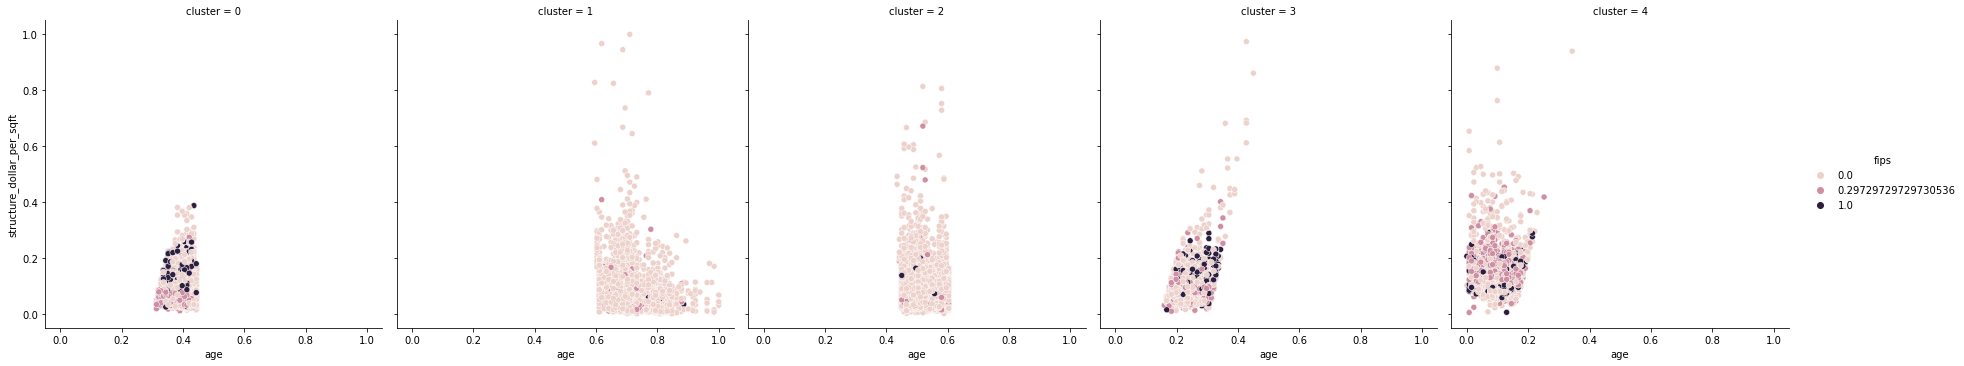

In [69]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

In [70]:
X = X_train_scaled[['age', 'land_dollar_per_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

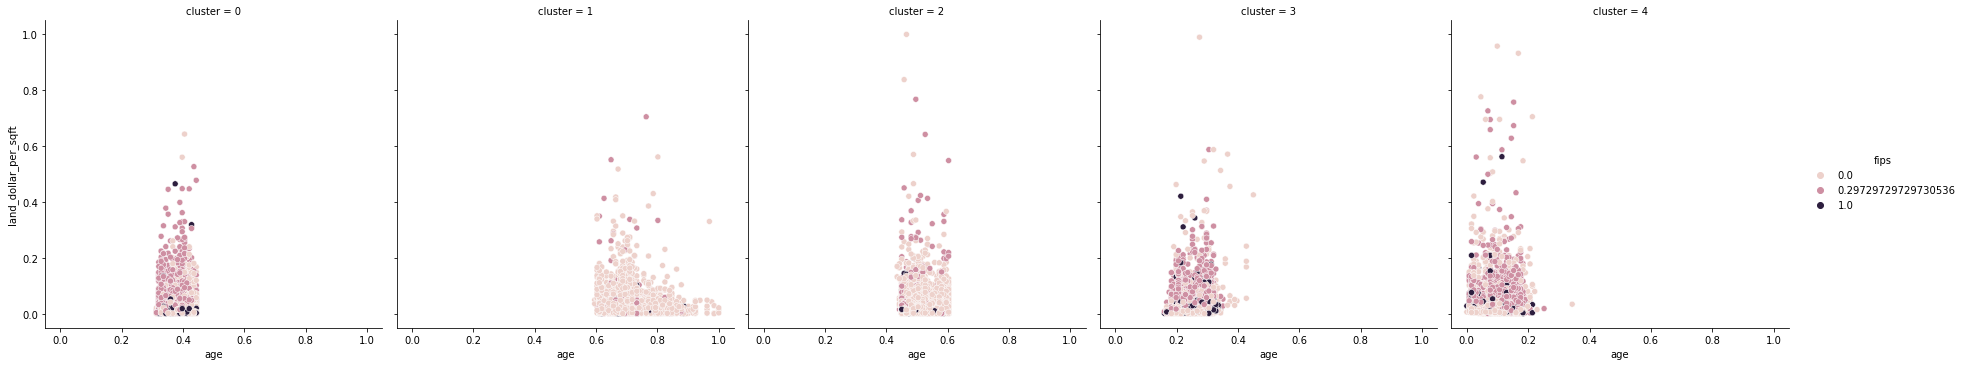

In [71]:

# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="land_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

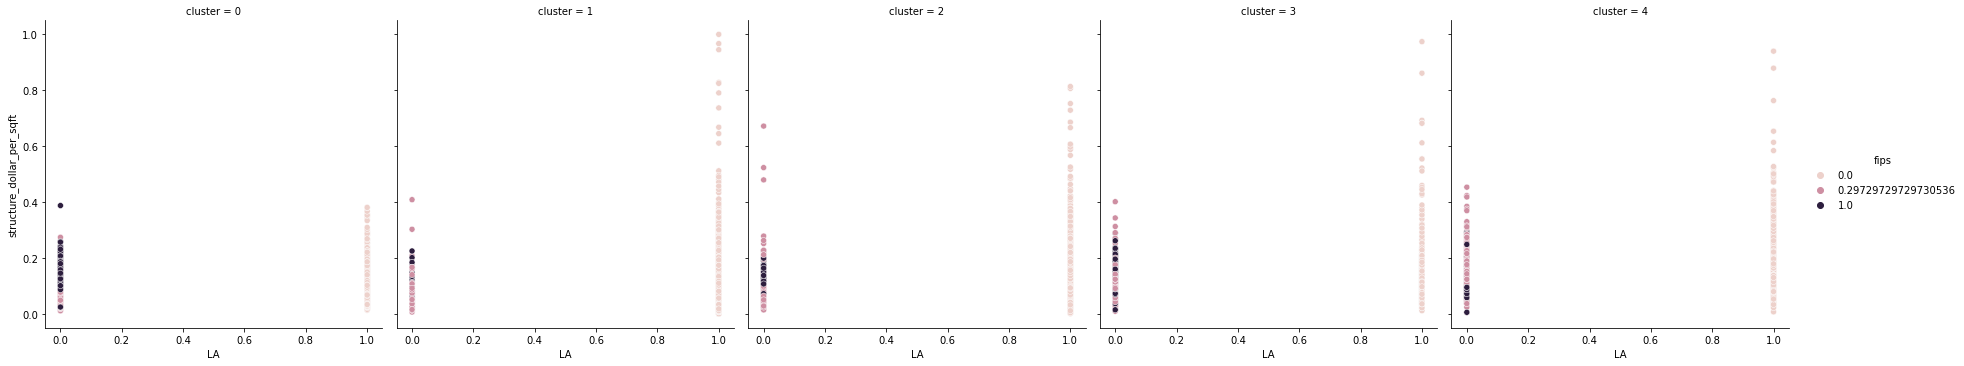

In [73]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="LA", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

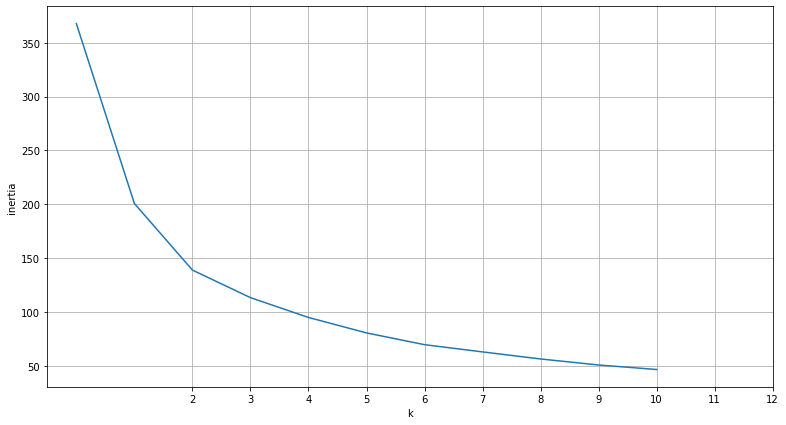

In [74]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [75]:
# It appears that the best number of centroids is around 4-5. So I'll try that again.

In [136]:
# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a proper copy
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

In [141]:
# Fit K-Means
X2 = train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans2 = KMeans(n_clusters=5)
kmeans2.fit(X2)

train_scaled['cluster'] = kmeans.labels_
train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
23120,0.166667,0.333333,0.193582,0.0,0.524562,0.878994,0.019009,0.0,0.717391,0.025856,0.005126,0.000886,0.006739,-0.033022,1.0,0.0,0.0,0.282609,0.281280,0.019009,0.077019,0.001722,0.250000,1
34788,0.166667,0.333333,0.219373,0.0,0.560193,0.555831,0.015023,0.0,0.507246,0.056828,0.016788,0.007722,0.019134,0.039248,1.0,0.0,0.0,0.492754,0.254171,0.015023,0.153062,0.017118,0.250000,2
56236,0.333333,0.333333,0.262708,0.0,0.497273,0.531652,0.018448,0.0,0.420290,0.083196,0.075379,0.068819,0.080238,-0.015456,1.0,0.0,0.0,0.579710,0.240622,0.018448,0.192927,0.124457,0.142857,0
43632,0.000000,0.166667,0.355226,0.0,0.502443,0.570489,0.009943,0.0,0.282609,0.134352,0.073012,0.055540,0.077570,-0.160252,1.0,0.0,0.0,0.717391,0.240132,0.009943,0.240233,0.177841,0.357143,0
46685,0.333333,0.500000,0.330334,0.0,0.821358,0.737236,0.015325,0.0,0.920290,0.040436,0.008758,0.001994,0.017319,0.056508,1.0,0.0,0.0,0.079710,0.432192,0.015325,0.076980,0.004492,0.214286,4


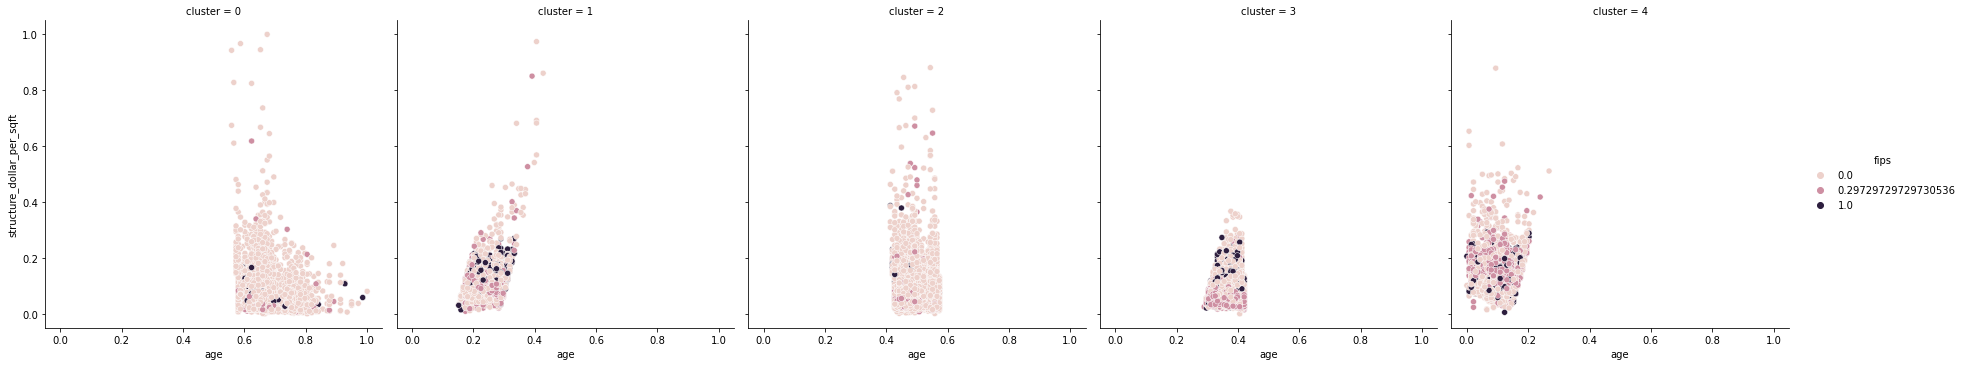

In [142]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=train_scaled)

In [143]:
pd.DataFrame(kmeans2.cluster_centers_, columns=X2.columns)

,age,structure_dollar_per_sqft
0,0.476173,0.081782
1,0.240415,0.106752
2,0.672191,0.087507
3,0.369868,0.076996
4,0.105645,0.139855


In [144]:
X2.shape, kmeans2.labels_.shape

((34955, 2), (34955,))

In [149]:
train_scaled['cluster'] = kmeans.labels_
train_scaled.groupby('cluster').mean()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
cluster,,,,,,,,,,,,,,,,,,,,,,,
0,0.112746,0.293227,0.179920,0.037697,0.466775,0.637632,0.015618,0.028107,0.327397,0.030196,0.018775,0.015492,0.020628,0.009761,0.922024,0.057320,0.020656,0.672603,0.268415,0.015618,0.087348,0.038702,0.329152
1,0.276059,0.409148,0.278810,0.257175,0.484874,0.698615,0.027062,0.208306,0.759247,0.049970,0.020961,0.013881,0.021974,0.017629,0.469870,0.388436,0.141694,0.240753,0.251324,0.027062,0.106660,0.033808,0.217527
2,0.142086,0.329537,0.175501,0.058191,0.467206,0.653020,0.018456,0.060188,0.523640,0.026807,0.015306,0.012254,0.017101,0.014590,0.857515,0.119956,0.022529,0.476360,0.273676,0.018456,0.081776,0.026601,0.314402
3,0.220270,0.424094,0.228965,0.244137,0.423411,0.674642,0.019406,0.260963,0.629913,0.030286,0.015994,0.012314,0.017171,0.023618,0.460732,0.419993,0.119275,0.370087,0.255446,0.019406,0.077005,0.029116,0.269381
4,0.389212,0.490556,0.389523,0.269285,0.480505,0.687080,0.026228,0.101519,0.894164,0.090239,0.034948,0.021434,0.037987,0.020216,0.431144,0.426312,0.142543,0.105836,0.265543,0.026228,0.139929,0.049140,0.195003


<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='age'>

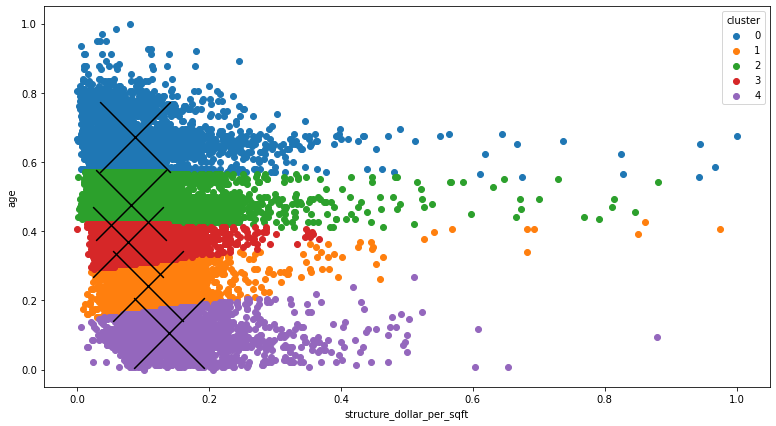

In [148]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.structure_dollar_per_sqft, subset.age, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train_scaled.groupby('cluster').mean().plot.scatter(y='age', x='structure_dollar_per_sqft', marker='x', s=5000, ax=ax, c='black')

### Hypothesis Test:

$H_0$: The population means for the 5 clusters are all equal (**no** significant difference)

$H_a$: The population means for the 5 clusters are not equal (there **is** a significant difference)

In [152]:
# Running an ANOVA test for all 5 clusters:

alpha = .05

cluster_one = train_scaled[train_scaled.cluster == 0].logerror
cluster_two = train_scaled[train_scaled.cluster == 1].logerror
cluster_three = train_scaled[train_scaled.cluster == 2].logerror
cluster_four = train_scaled[train_scaled.cluster == 3].logerror
cluster_five = train_scaled[train_scaled.cluster == 4].logerror

In [153]:
# The test:

import scipy.stats as stats

f, p = stats.f_oneway(cluster_one, cluster_two, cluster_three, cluster_four, cluster_five)
f, p

(5.687811450841082, 0.00014241126552386914)

In [156]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject null hypothesis")

We reject the null hypothesis


## Breakthrough:

- It appears as though the `age` and `structure_dollar_per_sqft` independent variables' variance are at least statistically significant 

In [102]:
# Fit K-Means
X = X_train_scaled[["latitude", "longitude"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
58160,0.083333,0.333333,0.111925,0.297297,0.294176,0.751024,0.013250,0.357143,0.587786,0.013324,0.007793,0.006473,0.008735,0.0,1.0,0.0,0.412214,0.241254,0.013250,0.061333,0.016904,0.357143,5
69027,0.083333,0.166667,0.147938,0.297297,0.017906,0.980679,0.002188,0.357143,0.702290,0.023465,0.021101,0.019491,0.019088,0.0,1.0,0.0,0.297710,0.198119,0.002188,0.087762,0.253643,0.214286,0
60376,0.083333,0.333333,0.147639,1.000000,0.617419,0.105923,0.013289,0.357143,0.480916,0.011137,0.009927,0.009350,0.009493,0.0,0.0,1.0,0.519084,0.206734,0.013289,0.041758,0.024197,0.357143,2
50394,0.000000,0.166667,0.133891,0.000000,0.403864,0.598904,0.014859,0.000000,0.335878,0.004890,0.001203,0.000733,0.002717,1.0,0.0,0.0,0.664122,0.393771,0.014859,0.019795,0.001985,0.357143,5
30686,0.250000,0.500000,0.341901,0.297297,0.106932,0.958963,0.007958,0.000000,0.900763,0.068635,0.027823,0.017776,0.035977,0.0,1.0,0.0,0.099237,0.287455,0.007958,0.127858,0.074358,0.271429,0


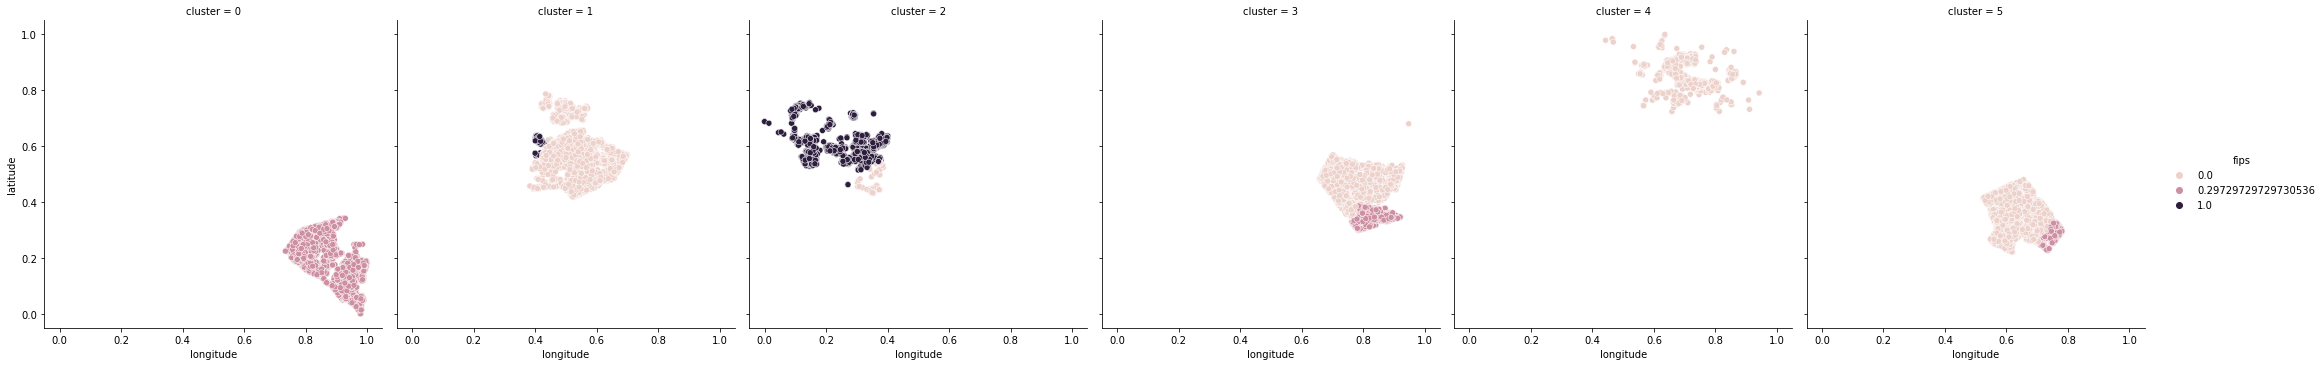

In [103]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="longitude", y="latitude", hue="fips", col="cluster", data=X_train_scaled)

#### This is actually a very interesting result 

It seems like the clustering actually did a pretty decent job of clustering by location data... and incidentally, when I ran the correlation matrix, location information was the most correlated than the other features... still not significantly so, but more so than the other features.

In [104]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

,latitude,longitude
0,0.192199,0.874486
1,0.563237,0.538979
2,0.595901,0.251902
3,0.437145,0.792178
4,0.864093,0.702828
5,0.341520,0.651034


In [105]:
# Adding back a county column to the train df in order to viz the counties:
train_viz = train.copy()

In [106]:
# separating by county

# converting fips code to int. Will need to convert to string if I import into Tableau.
train_viz['fips'] = train_viz['fips'].astype('int')

conditions = [
    (train_viz['fips'] == 6037),
    (train_viz['fips'] == 6059),
    (train_viz['fips'] == 6111)
    ]

county_list = ['Los Angeles', 'Orange', 'Ventura']

train_viz['county'] = np.select(conditions, county_list)
train_viz.shape
train_viz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34955 entries, 23120 to 73680
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   34955 non-null  float64
 1   bedroomcnt                    34955 non-null  float64
 2   calculatedfinishedsquarefeet  34955 non-null  float64
 3   fips                          34955 non-null  int64  
 4   latitude                      34955 non-null  float64
 5   longitude                     34955 non-null  float64
 6   lotsizesquarefeet             34955 non-null  float64
 7   roomcnt                       34955 non-null  float64
 8   yearbuilt                     34955 non-null  float64
 9   structuretaxvaluedollarcnt    34955 non-null  float64
 10  taxvaluedollarcnt             34955 non-null  float64
 11  landtaxvaluedollarcnt         34955 non-null  float64
 12  taxamount                     34955 non-null  float64
 1

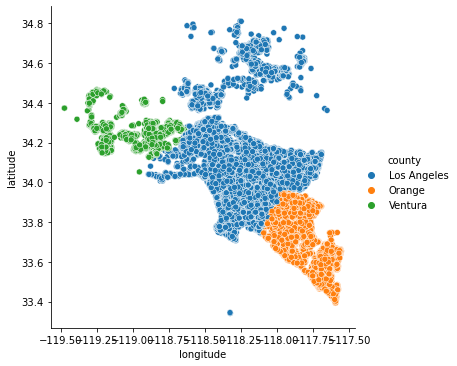

In [107]:
sns.relplot(x="longitude", y="latitude", hue="county", data=train_viz)

In [ ]:
# I'm not able to get any real clusters... so I'm going to try and focus on modeling and finish the MVP


In [ ]:
# Testing the log error between multiple 

In [110]:
#setting my alpha
alpha = .05

In [ ]:
X_train